# Demo

## Data loading

### Example dataset: Fashion MNIST

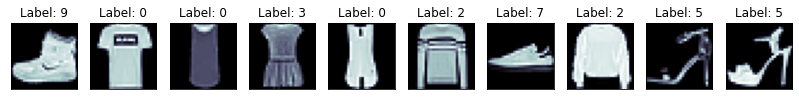

In [1]:
from data_samples import fashion_mnist

data = fashion_mnist()

### Custom dataset

The model can train on any dataset; however, the following requirements must be met:

* TODO
* 

## Training with default parameters

# Hyperparameter tuning

[Hyperopt](https://github.com/hyperopt/hyperopt) optimizes hyperparameters within a search space based on previous trials.

Here, the [Tree Parzen Estimator](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf) uses [Bayesian principles](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f#:~:text=The%20Tree%20Parzen%20Estimator%20is,will%20explore%20in%20further%20articles.) to adjust hyperparameters between calls to `NeuralNetwork.fit`.

The search space includes initialization and training parameters.

Referenced [hyperopt article](https://towardsdatascience.com/optimise-your-hyperparameter-tuning-with-hyperopt-861573239eb5).

In [4]:
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK

# Define ranges for hyperopt to search
search_space = dict(
    # Init params
    h_layers      = hp.quniform('h_layers',     1,5,1),
    shape         = hp.choice('shape',          ['flat', 'contracting', 'expanding']),
    max_height    = hp.quniform('max_height',   600,2500,1),
    shrink_factor = hp.uniform('shrink_factor', 0.5,1),
    # Training params
    batch_size           = hp.loguniform('batch_size',       3,    8), # => e^3 to e^8
    lr                   = hp.loguniform('lr',              -8.5, -7),
    keep_rates_min       = hp.loguniform('keep_rates_min',  -0.1,  0), # Best seem to be >= 0.9
    keep_rates_reshuffle = hp.choice('keep_rates_reshuffle',[True,False]),
)

# If desired, specify starting points for hyperparams
# via https://gist.github.com/jaikumarm/bca0e895ca19267d14d6ade194394191

def objective(search_space):
    # Initialize
    model = NeuralNetwork(
        inputs         = train_images.shape[1],
        outputs        = train_labels.shape[1],
        **{
            key: search_space[key] for key in [
                'h_layers', 'shape', 'max_height', 'shrink_factor',
            ]
        }   
    )

    # Pin the most recent models to the top        
    show_best    = 5
    show_recent  = 5
    summaries_df = pd.read_csv('summaries.csv', index_col=0)
    # Sort values and select best from top
    best_df   = summaries_df.sort_values('min_loss_val')
    best_df   = best_df if summaries_df.shape[0] < show_best \
        else best_df.iloc[0:show_best]
    # Select last rows
    recent_df = summaries_df if summaries_df.shape[0] < show_recent \
        else summaries_df.iloc[summaries_df.shape[0]-show_recent:]

    # Fit and return best loss value
    loss = model.fit(
        X       = train_images,
        y       = train_labels,
        x_val   = test_images,
        y_val   = test_labels,
        # By default, allow keep_rates_range to go up to 1
        keep_rates_range = [search_space['keep_rates_min'], 1],
        **{
            key: search_space[key] for key in [
                'batch_size', 'lr', 'keep_rates_reshuffle'
            ]
        },
        print_cache  = [
            f'Best {show_best} models:',          best_df,
            f'Most recent {show_recent} models:', recent_df
        ]

    )
    return dict(
        loss   = loss,
        status = STATUS_OK
    )

# Optimize hyperparameters via loss function, search space,
# and Tree Parzen Estimators, while saving summaries for each model
best = fmin(
    fn        = objective,
    space     = search_space,
    algo      = tpe.suggest,
    max_evals = 50
)

Best 5 models:                                        
  0%|          | 0/50 [00:16<?, ?trial/s, best loss=?]

,min_loss_val,max_acc_val,h_layers,heights,lr,batch_size,keep_rates,reshuff,max_strikes,max_consec,epochs_min_loss_val,total_sec
1.553061e+18,0.296820,0.8948,3,"flat, (1868 => 1868)",0.000727,1680,"range: (0.9355129444418089, 1)",True,2,2,9,411.99
6.378536e+17,0.299361,0.8958,2,"flat, (2147 => 2147)",0.000739,2509,"range: (0.9732144341134844, 1)",False,2,2,14,484.84
1.183797e+18,0.300882,0.8928,2,"expanding, (860 => 1318)",0.000766,1039,"range: (0.9963679433526818, 1)",False,2,2,8,119.59
2.192788e+18,0.302602,0.8945,2,"contracting, (2382 => 1427)",0.000892,979,"range: (0.9219362813698884, 1)",True,2,2,9,294.02
1.362338e+18,0.304246,0.8927,2,"contracting, (2372 => 2212)",0.000549,3193,"range: (0.9998225539494774, 1)",False,2,2,12,463.07


Most recent 5 models:                                 
  0%|          | 0/50 [00:16<?, ?trial/s, best loss=?]

,min_loss_val,max_acc_val,h_layers,heights,lr,batch_size,keep_rates,reshuff,max_strikes,max_consec,epochs_min_loss_val,total_sec
2.228268e+18,0.309001,0.8903,4,"flat, (1257 => 1257)",0.000712,2202,"range: (0.9818383588286673, 1)",True,2,2,7,355.92
8.511880e+17,0.309278,0.8893,2,"flat, (2277 => 2277)",0.000578,2521,"range: (0.9730401212750497, 1)",False,2,2,9,412.29
1.067276e+18,0.347681,0.8757,1,"expanding, (1268 => 1692)",0.000986,4554,"range: (0.9506594907788668, 1)",True,2,2,13,113.61
1.367086e+18,0.317464,0.8869,2,"flat, (1514 => 1514)",0.000735,1807,"range: (0.965780371799544, 1)",False,2,2,9,213.41
2.254605e+18,0.314946,0.8889,3,"expanding, (945 => 1032)",0.000372,968,"range: (0.990171437679217, 1)",False,2,2,8,191.71


Training w/ hyperparams:                              
  0%|          | 0/50 [00:16<?, ?trial/s, best loss=?]

,h_layers,heights,lr,batch_size,keep_rates,reshuff,max_strikes,max_consec
,3,"flat, (2064 => 2064)",0.000237,60,"range: (0.9837143956637605, 1)",True,2,2


Total strikes:    0/2                                 
Consec strikes:   0/2                                 
Performance By Epoch:                                 
  0%|          | 0/50 [00:16<?, ?trial/s, best loss=?]

,loss_train,loss_val,acc_train,acc_val,total_sec_elapsed
0,4.565998,4.566477,0.048067,0.0452,15.75


Weight Percentiles after Epoch 0:                     
Percentiles formatted as "(Range: Min => Max)"        
  0%|          | 0/50 [00:16<?, ?trial/s, best loss=?]

,all,99p,95p,50p
0,(0.4993 : -0.2367 => 0.2626),(0.2602 : -0.1301 => 0.1302),(0.1979 : -0.0989 => 0.0990),(0.0682 : -0.0341 => 0.0341)
1,(0.5243 : -0.2549 => 0.2693),(0.2602 : -0.1301 => 0.1300),(0.1978 : -0.0989 => 0.0989),(0.0681 : -0.0340 => 0.0341)
2,(0.5086 : -0.2473 => 0.2613),(0.2601 : -0.1300 => 0.1301),(0.1981 : -0.0990 => 0.0991),(0.0681 : -0.0341 => 0.0340)
3,(0.3986 : -0.2097 => 0.1889),(0.2610 : -0.1309 => 0.1301),(0.2003 : -0.1009 => 0.0994),(0.0675 : -0.0338 => 0.0337)


Training epoch 1:                                     
  0%|          | 0/50 [00:16<?, ?trial/s, best loss=?]

 32%|###2      | 325/1000 [00:33<01:10,  9.57it/s]


  0%|          | 0/50 [00:50<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

## Notes from hyperparameter tuning

Though hyperparameter trials and logging to `summaries.csv`, certain ranges for certain hyperparameters have generally led to lowest validation loss.

These ranges have been updated for subsequent calls to `hyperopt.fmin`, with expansion of thus-far unexplored ranges if the optimal ranges have tended toward either edge of the current ranges.

Hyperparameter | Min | Max
:-- | --: | --: 
`h_layers` | `1` | `4`
`keep_rates_min` | `0.92` | `1`
`lr` | `3e-4` | `9e-4`
`batch_size` | `500` | `4000`
